# Naive Model

## 1. Problem Description

The Household Power Consumption dataset is a multivariate time series dataset that describes
the electricity consumption for a single household over four years. The data was collected
between December 2006 and November 2010 and observations of power consumption within the
household were collected every minute. It is a multivariate series comprised of seven variables
(besides the date and time); they are:<br>
* global active power: The total active power consumed by the household (kilowatts).
* global reactive power: The total reactive power consumed by the household (kilowatts).
* voltage: Average voltage (volts).
* global intensity: Average current intensity (amps).
* sub metering 1: Active energy for kitchen (watt-hours of active energy).
* sub metering 2: Active energy for laundry (watt-hours of active energy).
* sub metering 3: Active energy for climate control systems (watt-hours of active energy).

Active and reactive energy refer to the technical details of alternative current. A fourth
sub-metering variable can be created by subtracting the sum of three defined sub-metering
variables from the total active energy. This dataset was introduced and analyzed in Chapter 16.
Refer to that chapter for more details if needed.

## 2. Load and Prepare Dataset

In [1]:
# load and clean-up the power usage dataset
from numpy import nan
from numpy import isnan
from pandas import read_csv

In [2]:
# fill missing values with a value at the same time one day ago
def fill_missing(values):
 one_day = 60 * 24
 for row in range(values.shape[0]):
  for col in range(values.shape[1]):
   if isnan(values[row, col]):
    values[row, col] = values[row - one_day, col]

In [3]:
# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False,
infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [4]:
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')

In [5]:
# fill missing
fill_missing(dataset.values)

In [6]:
# add a column for for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] +
values[:,6])

In [7]:
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

In [8]:
# resample minute data to total for each day for the power usage dataset
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True,
parse_dates=['datetime'], index_col=['datetime'])
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1


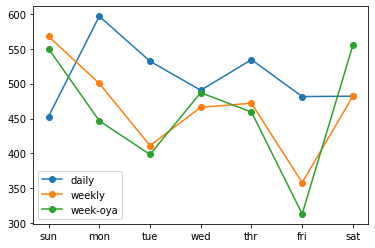

In [11]:
# naive forecast strategies for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def split_dataset(data):
 # split into standard weeks
 train, test = data[1:-328], data[-328:-6]
 # restructure into windows of weekly data
 train = array(split(train, len(train)/7))
 test = array(split(test, len(test)/7))
 return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
 scores = list()
 # calculate an RMSE score for each day
 for i in range(actual.shape[1]):
  # calculate mse
  mse = mean_squared_error(actual[:, i], predicted[:, i])
  # calculate rmse
  rmse = sqrt(mse)
  # store
  scores.append(rmse)
 # calculate overall RMSE
 s = 0
 for row in range(actual.shape[0]):
  for col in range(actual.shape[1]):
   s += (actual[row, col] - predicted[row, col])**2
 score = sqrt(s / (actual.shape[0] * actual.shape[1]))
 return score, scores

# summarize scores
def summarize_scores(name, score, scores):
 s_scores = ', '.join(['%.1f' % s for s in scores])
 print('%s: [%.3f] %s' % (name, score, s_scores))

# evaluate a single model
def evaluate_model(model_func, train, test):
 # history is a list of weekly data
 history = [x for x in train]
 # walk-forward validation over each week
 predictions = list()
 for i in range(len(test)):
  # predict the week
  yhat_sequence = model_func(history)
  # store the predictions
  predictions.append(yhat_sequence)
  # get real observation and add to history for predicting the next week
  history.append(test[i, :])
 predictions = array(predictions)
 # evaluate predictions days for each week
 score, scores = evaluate_forecasts(test[:, :, 0], predictions)
 return score, scores

# daily persistence model
def daily_persistence(history):
  # get the data for the prior week
 last_week = history[-1]
 # get the total active power for the last day
 value = last_week[-1, 0]
 # prepare 7 day forecast
 forecast = [value for _ in range(7)]
 return forecast

# weekly persistence model
def weekly_persistence(history):
 # get the data for the prior week
 last_week = history[-1]
 return last_week[:, 0]

# week one year ago persistence model
def week_one_year_ago_persistence(history):
 # get the data for the prior week
 last_week = history[-52]
 return last_week[:, 0]

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0,
infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['daily'] = daily_persistence
models['weekly'] = weekly_persistence
models['week-oya'] = week_one_year_ago_persistence
# evaluate each model
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
for name, func in models.items():
 # evaluate and get scores
 score, scores = evaluate_model(func, train, test)
 # summarize scores
 summarize_scores(name, score, scores)
 # plot scores
 pyplot.plot(days, scores, marker='o', label=name)
# show plot
pyplot.legend()
pyplot.show()